# Сверточные и нейронные сети

In [ ]:
!pip install -q catalyst

     |████████████████████████████████| 446 kB 5.2 MB/s 
     |████████████████████████████████| 191 kB 66.2 MB/s 
     |████████████████████████████████| 125 kB 66.7 MB/s 


In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

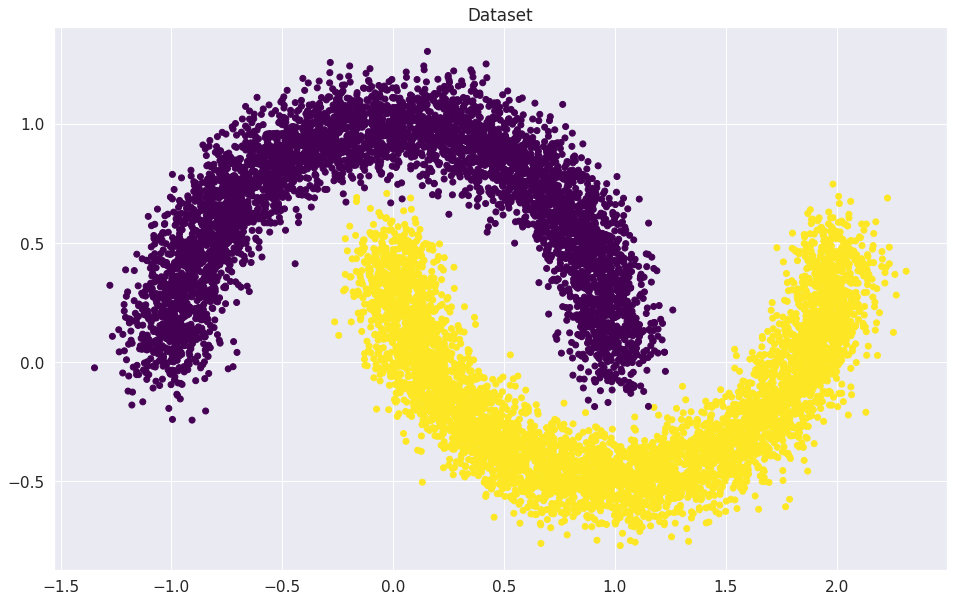

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [ ]:
X_train

array([[ 0.50202001, -0.33758011],
       [-0.02001968,  0.239079  ],
       [ 0.57026061,  0.81166576],
       ...,
       [ 0.32163146, -0.35671524],
       [ 2.01344205,  0.03227946],
       [ 0.17908235,  0.93097468]])

In [ ]:
X_train_t =  torch.tensor(X_train, dtype=torch.float32)
y_train_t =  torch.tensor(y_train, dtype=torch.float32)
X_val_t =  torch.tensor(X_val, dtype=torch.float32)
y_val_t =  torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`. 

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [ ]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1** Сколько обучаемых параметров у получившейся модели?

**Ответ:** in_features * output_features + output_features = 2 * 1 + 1 = 3

2 - W11, W12, 1 - bias 

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp.squeeze(1), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5625
Iteration: 7500
Batch accuracy: 0.765625
Iteration: 15000
Batch accuracy: 0.7890625
Iteration: 22500
Batch accuracy: 0.7890625
Iteration: 30000
Batch accuracy: 0.8046875
Iteration: 37500
Batch accuracy: 0.8046875
Iteration: 45000
Batch accuracy: 0.8046875
Iteration: 52500
Batch accuracy: 0.8203125
Iteration: 60000
Batch accuracy: 0.8203125
Iteration: 67500
Batch accuracy: 0.8203125
Iteration: 75000
Batch accuracy: 0.8203125
Iteration: 82500
Batch accuracy: 0.8203125
Iteration: 90000
Batch accuracy: 0.8203125

Iteration: 90047.Convergence. Stopping iterations.


**Вопрос 2**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 90047

### Визуализируем результаты

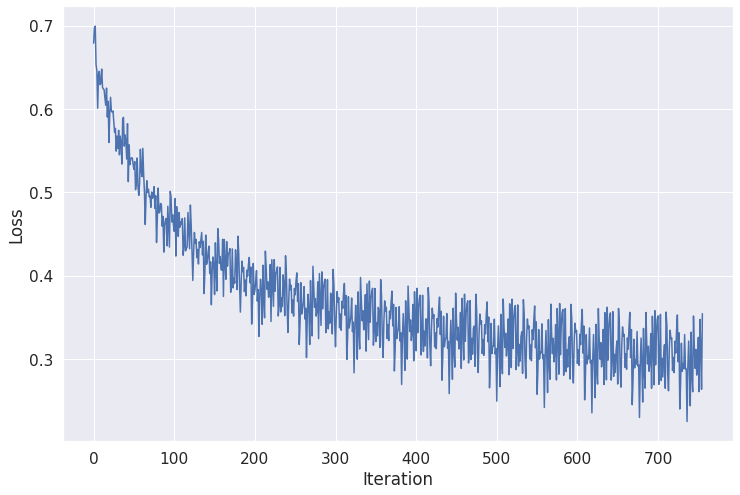

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

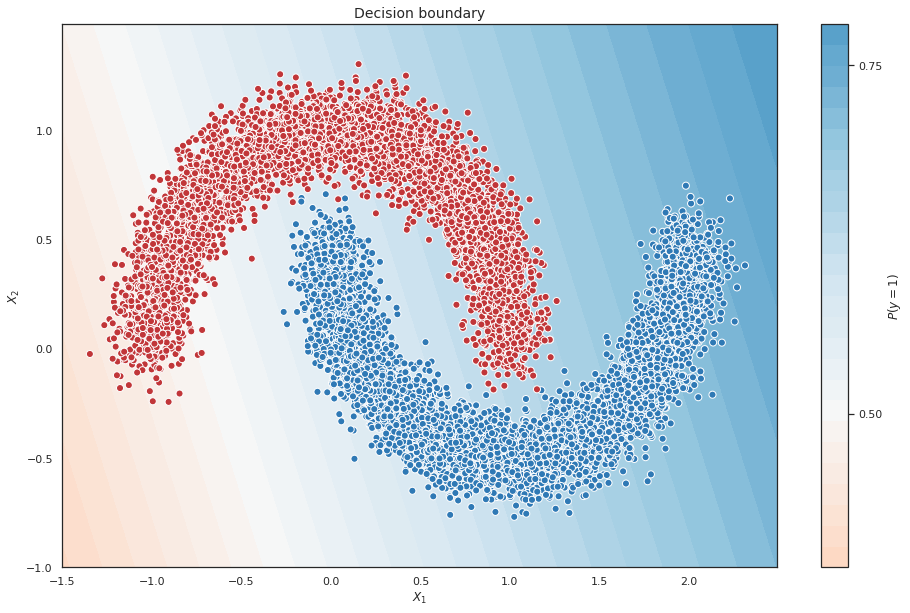

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    y_true = np.array([])
    for x_batch, y_batch in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
        y_true = np.hstack((y_true, y_batch))
    predictions = predictions
    return predictions.flatten(), y_true

In [ ]:
y_pred, y_true = predict(val_dataloader, linear_regression)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.86      1272
         1.0       0.86      0.86      0.86      1228

    accuracy                           0.86      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.86      0.86      0.86      2500



**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.86

### MNIST

In [ ]:
import os
from catalyst.contrib.datasets import MNIST

train_dataset = MNIST(root=os.getcwd(), train=True, download=True)
val_dataset = MNIST(root=os.getcwd(), train=False)
train_dataloader = DataLoader(train_dataset, batch_size=128)
valid_dataloader = DataLoader(val_dataset, batch_size=128)

0it [00:00, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


0it [00:00, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw


0it [00:00, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


0it [00:00, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.8/dist-packages/catalyst/contrib/datasets/misc.py:188: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.8/dist-packages/catalyst/contrib/datasets/mnist.py:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data)


In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [ ]:
activation = nn.ELU

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8759333333333333
Loader: valid. Accuracy: 0.8833714285714286
Epoch: 2
Loader: train. Accuracy: 0.9415666666666667
Loader: valid. Accuracy: 0.94
Epoch: 3
Loader: train. Accuracy: 0.95405
Loader: valid. Accuracy: 0.9516142857142857
Epoch: 4
Loader: train. Accuracy: 0.9617166666666667
Loader: valid. Accuracy: 0.9608285714285715
Epoch: 5
Loader: train. Accuracy: 0.9671
Loader: valid. Accuracy: 0.9643285714285714
Epoch: 6
Loader: train. Accuracy: 0.9684166666666667
Loader: valid. Accuracy: 0.9672428571428572
Epoch: 7
Loader: train. Accuracy: 0.9713833333333334
Loader: valid. Accuracy: 0.9698142857142857
Epoch: 8
Loader: train. Accuracy: 0.9701166666666666
Loader: valid. Accuracy: 0.9692285714285714
Epoch: 9
Loader: train. Accuracy: 0.97425
Loader: valid. Accuracy: 0.9729142857142857
Epoch: 10
Loader: train. Accuracy: 0.9764
Loader: valid. Accuracy: 0.9740571428571428


Попробуйте разные функции активации. Позапускайте ячейки сверху несколько раз изменив функции активации. После каждого обучения запустите одну из ячеек снизу. Таким образом мы получим график accuracy/epoch для каждой функции активации.

In [ ]:
plain_accuracy = accuracy["valid"]

In [ ]:
relu_accuracy = accuracy["valid"]

In [ ]:
leaky_relu_accuracy = accuracy["valid"]

In [ ]:
elu_accuracy = accuracy["valid"]

### Accuracy

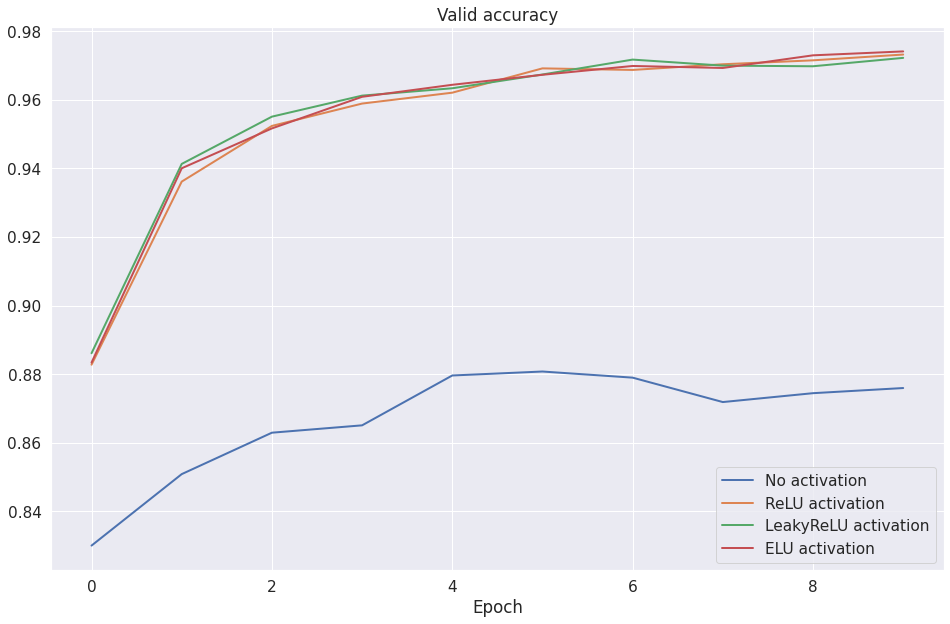

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

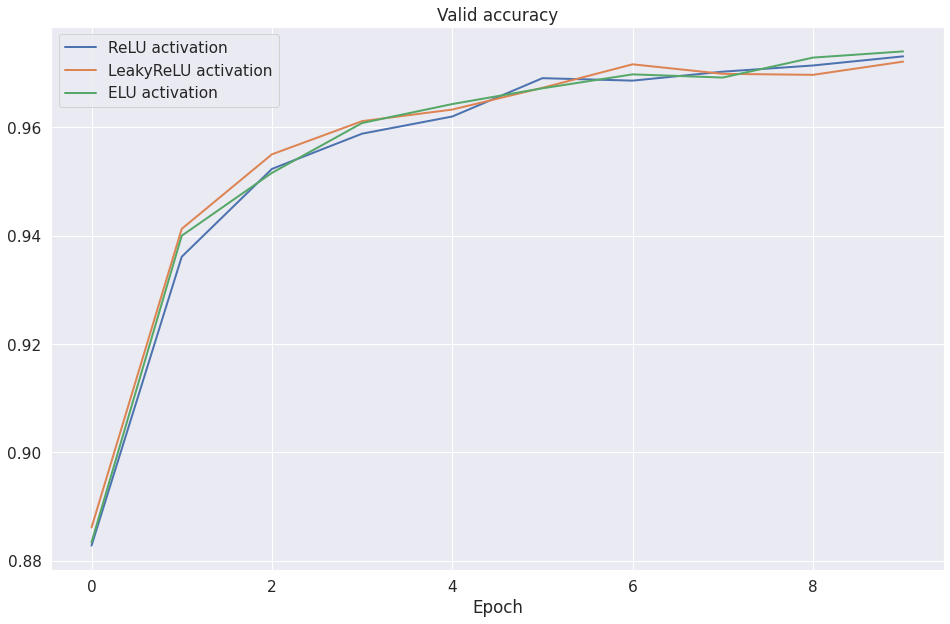

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4** Какая из активаций показала наивысший `accuracy`?

**Ответ:** LeakyReLU

## Сверточные слои

### Ядра

In [ ]:
# необходимо импортировать свою картинку
# это можно сделать либо с помощью !wget, либо через интерфейс colab'а слева
# в разделе "Files"
!wget https://yandex-images.clstorage.net/Nc5ZB5096/881410E0vd/HarzOjflK4uxHzsNTb0WhvmjIasE8vCXCv_UlCPgheCaXw5WqKChhlK2Q6rr3cKLTw-TXQC3qcgck24RThgNzVrr_SEstGSIo0h9T1u1FsTvu2-dONvX5iXb4uQL17iKsn0DVr_r9spO8A7HhdKTqCVx9Adm68e8Q4ZaPBsyTug9ir9WQPYcjYw7GQsuuzGCv60YoizG3MoS1OPSCeiynr1hH2C559vqMeUK2o-Wk5wRS8wcQ_zztUi0bxwVKkbOJ7eebU7uNqGuJyMxOYk2n7CNOb0s1NnVFP3s0RXjhZW6VjhEtMzf9Bj0CdG0lbWkGlHkIVLh67F8tl8XNB554ReOu2J14Su8gToBPQCbE566jQigLN7t9hDv7doPxpWFmn8fU4jM3doEyQ3trLCWmgpsxw5z9veLdZhACiMBadw9tqtcX_QZuKcPMCc3hTWxsLgOogz6zssH0uPUKf2Lm5N8N3a1wsX1IucZzrCUkaM1Ss4ZXe7ruU2UXSE4EFLvJJScR1LPELikJg81EZoIsZmOApEO4N_DK9Tz4SnnqLiQRClBu-XS0AXKDe6dmp6oJX3rN1nR7JVJv1sEHzFK7DedpV5f7jOpoAonGiegEJeisQK_K_vv1hLy0t8K0L6_uWMZYpvI2to3wAnXq52JhQZx7wNX9dKpd6tkPgYiUNM9nYBWTvIUg5IvPhQalzOeg5UPvC_fx-oI1OHfLsqir75kM1OU-erYMsQcyY-Rqpo3VMg0dM_buVWYRyE_AnnlOYOYU1HxLYCuOiIdBoojp6W1LrUF4-__F9PVyhzig4uedilDqMrXygTlC8mRtrqPBWzWCHnt1YRIlEMaJAlR8A-Xi2184ByJrDcMMCCJP7S-vwGwMu36-yLc5coFwIGBuEUrYr_Mwug6xCjLl6a4mDR87jtH9duzX4ZCKz4aVdw1rJtQcfQpp4oULQ4MuzuPu44ZgxP7ye826s_fL-0 -O sample_photo.jpg

--2022-12-21 10:34:37--  https://yandex-images.clstorage.net/Nc5ZB5096/881410E0vd/HarzOjflK4uxHzsNTb0WhvmjIasE8vCXCv_UlCPgheCaXw5WqKChhlK2Q6rr3cKLTw-TXQC3qcgck24RThgNzVrr_SEstGSIo0h9T1u1FsTvu2-dONvX5iXb4uQL17iKsn0DVr_r9spO8A7HhdKTqCVx9Adm68e8Q4ZaPBsyTug9ir9WQPYcjYw7GQsuuzGCv60YoizG3MoS1OPSCeiynr1hH2C559vqMeUK2o-Wk5wRS8wcQ_zztUi0bxwVKkbOJ7eebU7uNqGuJyMxOYk2n7CNOb0s1NnVFP3s0RXjhZW6VjhEtMzf9Bj0CdG0lbWkGlHkIVLh67F8tl8XNB554ReOu2J14Su8gToBPQCbE566jQigLN7t9hDv7doPxpWFmn8fU4jM3doEyQ3trLCWmgpsxw5z9veLdZhACiMBadw9tqtcX_QZuKcPMCc3hTWxsLgOogz6zssH0uPUKf2Lm5N8N3a1wsX1IucZzrCUkaM1Ss4ZXe7ruU2UXSE4EFLvJJScR1LPELikJg81EZoIsZmOApEO4N_DK9Tz4SnnqLiQRClBu-XS0AXKDe6dmp6oJX3rN1nR7JVJv1sEHzFK7DedpV5f7jOpoAonGiegEJeisQK_K_vv1hLy0t8K0L6_uWMZYpvI2to3wAnXq52JhQZx7wNX9dKpd6tkPgYiUNM9nYBWTvIUg5IvPhQalzOeg5UPvC_fx-oI1OHfLsqir75kM1OU-erYMsQcyY-Rqpo3VMg0dM_buVWYRyE_AnnlOYOYU1HxLYCuOiIdBoojp6W1LrUF4-__F9PVyhzig4uedilDqMrXygTlC8mRtrqPBWzWCHnt1YRIlEMaJAlR8A-Xi2184ByJrDcMMCCJP7S-vwGwMu36-yLc5coFwIGBuEUrYr_Mwug6xCjLl6a4mD

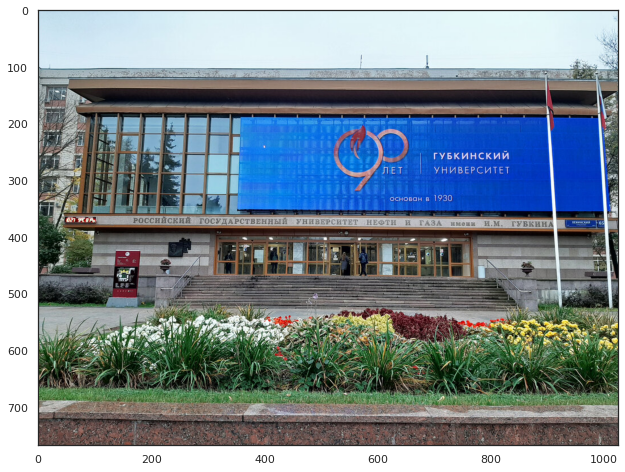

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

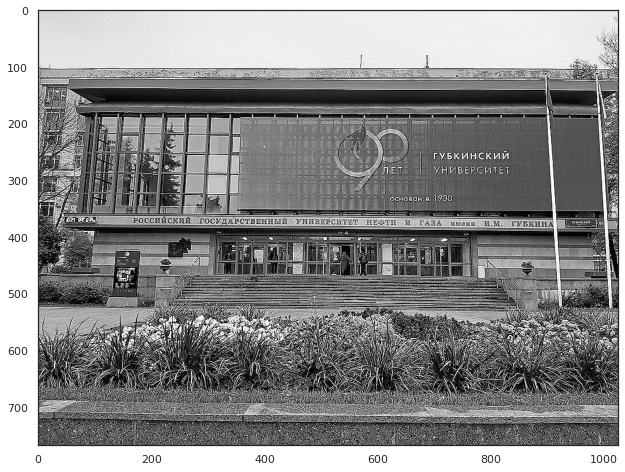

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5** Как вы считаете, как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 2, 4, 5, 6

### LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Давайте посмотрим на архитектуру, предложенную еще в 1998 году!

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42+epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9188
Loader: valid. Accuracy: 0.9261714285714285
Epoch: 2
Loader: train. Accuracy: 0.97515
Loader: valid. Accuracy: 0.9753285714285714
Epoch: 3
Loader: train. Accuracy: 0.9821833333333333
Loader: valid. Accuracy: 0.9819285714285715
Epoch: 4
Loader: train. Accuracy: 0.9860666666666666
Loader: valid. Accuracy: 0.9855571428571429
Epoch: 5
Loader: train. Accuracy: 0.9884833333333334
Loader: valid. Accuracy: 0.9875857142857143
Epoch: 6
Loader: train. Accuracy: 0.9895833333333334
Loader: valid. Accuracy: 0.9888142857142858
Epoch: 7
Loader: train. Accuracy: 0.9903166666666666
Loader: valid. Accuracy: 0.9893
Epoch: 8
Loader: train. Accuracy: 0.9903166666666666
Loader: valid. Accuracy: 0.9889
Epoch: 9
Loader: train. Accuracy: 0.9923166666666666
Loader: valid. Accuracy: 0.9907142857142858
Epoch: 10
Loader: train. Accuracy: 0.99235
Loader: valid. Accuracy: 0.9908857142857143


In [ ]:
линет_ауекураси = accuracy["valid"]

Сравним с предыдущем пунктом

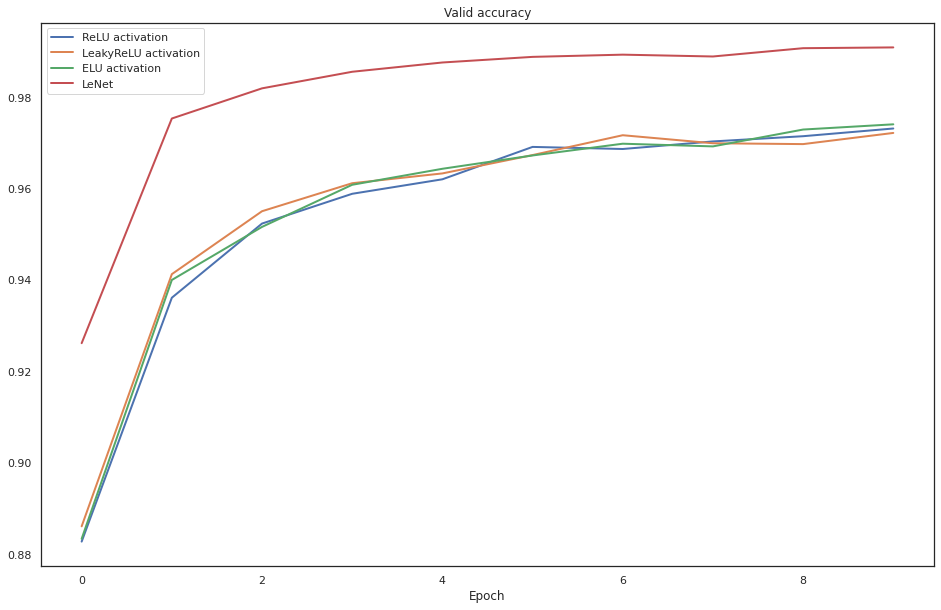

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), линет_ауекураси, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99 на тестовой выборке, 0.992 на обучающей выборке